# Оптимизация маркетинговых затрат в Яндекс.Афише

# Описание проекта

Задача проекта: Определить рекомендации для оптимизации  маркетинговых затрат.
    
    Данные для анализа:
    - лог сервера с данными о посещениях сайта Яндекс.Афиши,
    - выгрузка всех заказов за этот период,
    - статистика рекламных расходов.

## Описание данных

Таблица visits (лог сервера с информацией о посещениях сайта):

    Uid — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Start Ts — дата и время начала сессии
    End Ts — дата и время окончания сессии
    Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):

    Uid — уникальный id пользователя, который сделал заказ
    Buy Ts — дата и время заказа
    Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):

    source_id — идентификатор рекламного источника
    dt — дата
    costs — затраты на этот рекламный источник в этот день

## План действий

1. Предподготовка данных
2. Расчет метрик по устройствам и по рекламным источникам и во времени.

Продукт

    Сколько людей пользуются в день, неделю, месяц?
    Сколько сессий в день?
    Сколько длится одна сессия?
    Как часто люди возвращаются?

Продажи

    Когда люди начинают покупать?
    Сколько раз покупают за период?
    Какой средний чек?
    Сколько денег приносят? (LTV)

Маркетинг

    Сколько денег потратили? Всего / на каждый источник / по времени
    Сколько стоило привлечение одного покупателя из каждого источника?
    На сколько окупились расходы? (RMI)

In [59]:
from matplotlib import pyplot as plt # выгружаем необходимые библиотеки
import pandas as pd
import numpy as np
from math import factorial
from scipy import stats as st
import math as mt
from functools import reduce
import seaborn as sns
import warnings; warnings.filterwarnings(action='once')
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")

In [60]:
pd.set_option('display.float_format', lambda x: '%.3f' % x) #изменение глобальной настройки отображения 

## Предподготовка данных

In [61]:
def info_data(data):
    '''Принимает таблицу, возвращает первые 15 строк, общую информацию, наличие пропусков и дубликатов'''
    print(data.head(15))
    display(data.info())
    print('Количество пропусков в таблце:', data.isnull().sum())
    print('Количество дубликатов в таблце:',data.duplicated().sum())

In [62]:
visits = pd.read_csv('/datasets/visits_log.csv')
info_data(visits)

     Device               End Ts  Source Id             Start Ts  \
0     touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1   desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2     touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3   desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4   desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   
5   desktop  2017-09-03 21:36:00          5  2017-09-03 21:35:00   
6   desktop  2018-01-30 12:09:00          1  2018-01-30 11:13:00   
7     touch  2017-11-05 15:15:00          3  2017-11-05 15:14:00   
8   desktop  2017-07-19 10:44:00          3  2017-07-19 10:41:00   
9   desktop  2017-11-08 13:43:00          5  2017-11-08 13:42:00   
10  desktop  2017-07-14 12:44:00          5  2017-07-14 12:43:00   
11  desktop  2018-01-25 19:41:00          1  2018-01-25 19:37:00   
12  desktop  2018-02-06 15:50:00          4  2018-02-06 15:45:00   
13  desktop  2017-11-27 14:43:00          3  201

None

Количество пропусков в таблце: Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64
Количество дубликатов в таблце: 0


Датасет представлен таблицей из 5 столбцов и 35940 строк. Для дальнейшего анализа необходимо привести столбцы End Ts и Start Ts к формату datetime, столбец Uid к типу int.
Так же, для удобства чтения, приведем названия столбцов к нижнему регистру.

In [63]:
visits.set_axis(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], axis = 'columns',\
                inplace = True)# приводим назание столбцов к нижнему регистру
display(visits.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [64]:
#visits['uid'] = visits['uid'].astype('int64')
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits.info()
print(visits.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
device       359400 non-null object
end_ts       359400 non-null datetime64[ns]
source_id    359400 non-null int64
start_ts     359400 non-null datetime64[ns]
uid          359400 non-null uint64
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB
    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   
5  desktop 2017-09-03 21:36:00          5 2017-09-03 21:35:00   
6  desktop 2018-01-30 12:09:00          1 2018-01-30 11:13:00   
7    touch 2017-11-05 15:15:00          3 2017-11-05 15:14:00   
8  desktop 2017-07-19 10:44:0

In [65]:
orders = pd.read_csv('/datasets/orders_log.csv')
info_data(orders)

                 Buy Ts  Revenue                   Uid
0   2017-06-01 00:10:00   17.000  10329302124590727494
1   2017-06-01 00:25:00    0.550  11627257723692907447
2   2017-06-01 00:27:00    0.370  17903680561304213844
3   2017-06-01 00:29:00    0.550  16109239769442553005
4   2017-06-01 07:58:00    0.370  14200605875248379450
5   2017-06-01 08:43:00    0.180  10402394430196413321
6   2017-06-01 08:54:00    1.830  12464626743129688638
7   2017-06-01 09:22:00    1.220   3644482766749211722
8   2017-06-01 09:22:00    3.300  17542070709969841479
9   2017-06-01 09:23:00    0.370   1074355127080856382
10  2017-06-01 09:58:00    2.810  12888070354554424008
11  2017-06-01 10:27:00    1.220   4409266971612110231
12  2017-06-01 10:33:00    9.780   8635489015105716934
13  2017-06-01 10:38:00    1.830   8995168848618027177
14  2017-06-01 10:38:00    2.080   2050423809815667474
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     5

None

Количество пропусков в таблце: Buy Ts     0
Revenue    0
Uid        0
dtype: int64
Количество дубликатов в таблце: 0


 Датасет представлен таблицей из 3 столбцов и 50415 строк. Для дальнейшего анализа необходимо привести столбец Buy Ts к формату datetime. Так же, для удобства чтения, приведем названия столбцов к нижнему регистру. В дополнительной информации к данным в столбце Revenue не указан порядок исчесления. Тип float не поддерживает сложную арифметику, поэтому необходимо привести столбец к типу int.

In [66]:
orders.set_axis(['buy_ts', 'revenue', 'uid'], axis = 'columns', inplace = True)
#orders['uid'] = orders['uid'].astype('int64')
#orders['revenue'] = orders['revenue'] * 1000 
orders['revenue'] = orders['revenue'].astype('int64')
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
orders.info()
print(orders.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null int64
uid        50415 non-null uint64
dtypes: datetime64[ns](1), int64(1), uint64(1)
memory usage: 1.2 MB
               buy_ts  revenue                   uid
0 2017-06-01 00:10:00       17  10329302124590727494
1 2017-06-01 00:25:00        0  11627257723692907447
2 2017-06-01 00:27:00        0  17903680561304213844
3 2017-06-01 00:29:00        0  16109239769442553005
4 2017-06-01 07:58:00        0  14200605875248379450
5 2017-06-01 08:43:00        0  10402394430196413321
6 2017-06-01 08:54:00        1  12464626743129688638
7 2017-06-01 09:22:00        1   3644482766749211722
8 2017-06-01 09:22:00        3  17542070709969841479
9 2017-06-01 09:23:00        0   1074355127080856382


In [67]:
marketing = pd.read_csv('/datasets/costs.csv')
info_data(marketing)

    source_id          dt  costs
0           1  2017-06-01 75.200
1           1  2017-06-02 62.250
2           1  2017-06-03 36.530
3           1  2017-06-04 55.000
4           1  2017-06-05 57.080
5           1  2017-06-06 40.390
6           1  2017-06-07 40.590
7           1  2017-06-08 56.630
8           1  2017-06-09 40.160
9           1  2017-06-10 43.240
10          1  2017-06-11 21.680
11          1  2017-06-12 27.480
12          1  2017-06-13 44.660
13          1  2017-06-14 30.700
14          1  2017-06-15 39.710
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

Количество пропусков в таблце: source_id    0
dt           0
costs        0
dtype: int64
Количество дубликатов в таблце: 0


In [68]:
#marketing['costs'] = marketing['costs'] * 1000
marketing['costs'] = marketing['costs'].astype('int64')
marketing['dt'] = pd.to_datetime(marketing['dt'])
marketing.info()
print(marketing.head(15))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null datetime64[ns]
costs        2542 non-null int64
dtypes: datetime64[ns](1), int64(2)
memory usage: 59.7 KB
    source_id         dt  costs
0           1 2017-06-01     75
1           1 2017-06-02     62
2           1 2017-06-03     36
3           1 2017-06-04     55
4           1 2017-06-05     57
5           1 2017-06-06     40
6           1 2017-06-07     40
7           1 2017-06-08     56
8           1 2017-06-09     40
9           1 2017-06-10     43
10          1 2017-06-11     21
11          1 2017-06-12     27
12          1 2017-06-13     44
13          1 2017-06-14     30
14          1 2017-06-15     39


Данные для анализа приведены к необходимым типам, проверены на наличие дублей и пропусков. Дополнительно стоит выяснить единицу измерения в данных о выручке и расходах. Для дальнейшего анализа, было принято решение о приведении сумм к тысячным показателям, округлив значения для форматирования типа, тем не менее, в дополнительной информации стоит указывать идиницы измерения. 

## Отчеты и метрики

### Продукт

In [69]:
"""Сколько людей пользуются в день, неделю, месяц?"""
#Чтобы посчитать недельное и месячное использование, выделим в отдельные столбцы год, месяц и неделю, 
#а также полную дату в таблице visits.
visits['session_year']  = visits['start_ts'].astype('datetime64[Y]')
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week']  = visits['start_ts'].astype('datetime64[W]')
visits['session_date'] = visits['start_ts'].astype('datetime64[D]')
print(visits.head())

    device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid session_year session_month session_week session_date  
0  16879256277535980062   2017-01-01    2017-12-01   2017-12-14   2017-12-20  
1    104060357244891740   2018-01-01    2018-02-01   2018-02-15   2018-02-19  
2   7459035603376831527   2017-01-01    2017-07-01   2017-06-29   2017-07-01  
3  16174680259334210214   2018-01-01    2018-05-01   2018-05-17   2018-05-20  
4   9969694820036681168   2017-01-01    2017-12-01   2017-12-21   2017-12-27  


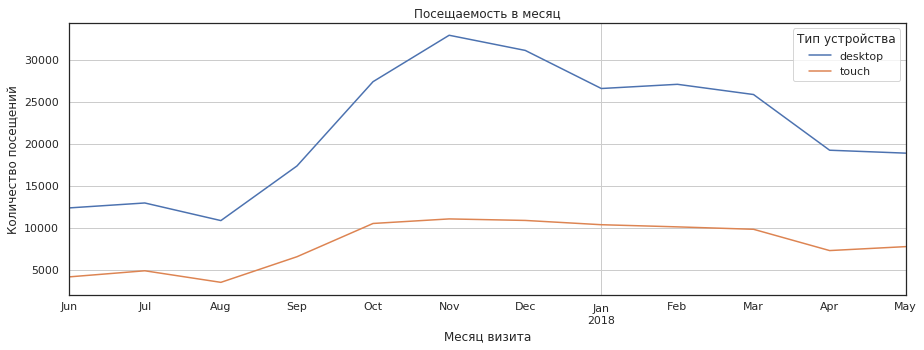

In [70]:
visits_month = visits.pivot_table(index='session_month', columns='device', values='uid', aggfunc='count').\
plot(figsize = (15,5), title = 'Посещаемость в месяц', grid=True)
plt.ylabel('Количество посещений')
plt.xlabel('Месяц визита')
plt.legend(title='Тип устройства');

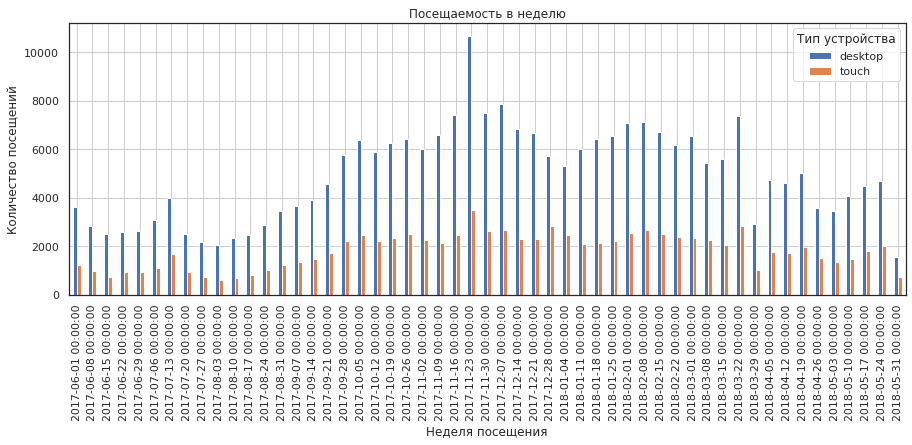

In [71]:
visits_week = visits.pivot_table(index='session_week', columns='device', values='uid', aggfunc='count').\
plot(figsize = (15,5),  title = 'Посещаемость в неделю', grid=True, kind='bar')
plt.xlabel('Неделя посещения')
plt.ylabel('Количество посещений')
plt.legend(title='Тип устройства');

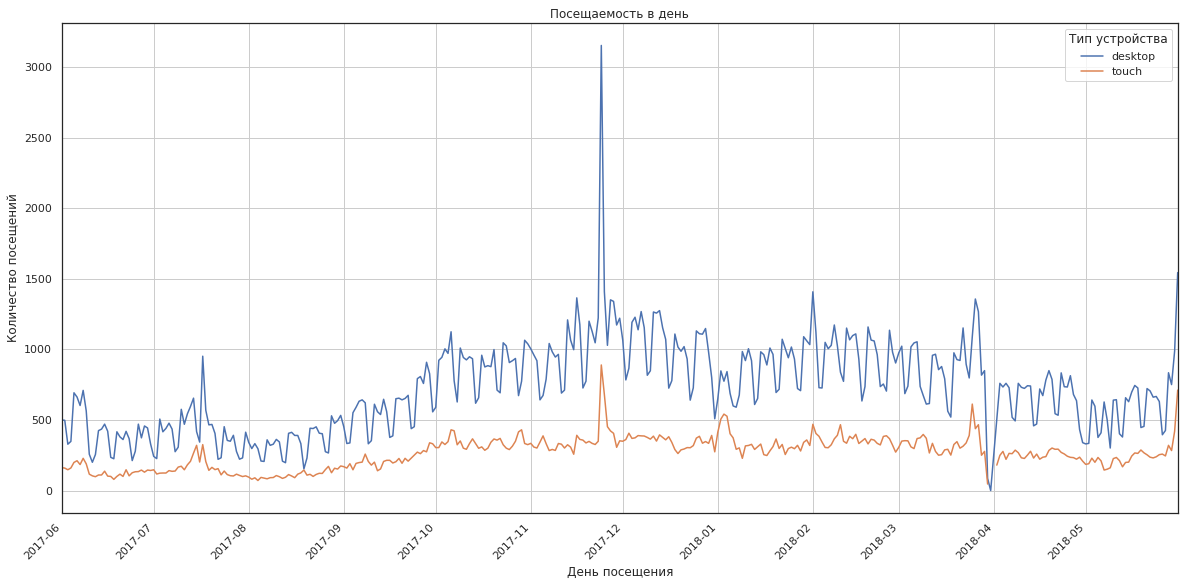

In [72]:
visits_week = visits.pivot_table(index='session_date', columns='device', values='uid', aggfunc='count').\
plot(figsize = (20,10), title = 'Посещаемость в день', grid=True)
plt.xticks(rotation= 45)
plt.xlabel('День посещения')
plt.ylabel('Количество посещений')
plt.legend(title='Тип устройства');

In [73]:
dau_total_touch = visits.query('device == "touch"').groupby('session_date').agg({'uid': 'nunique'}).mean()
dau_total_desktop = visits.query('device == "desktop"').groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total_touch = visits.query('device == "touch"').groupby(['session_year', 'session_week']).\
agg({'uid': 'nunique'}).mean()
wau_total_desktop = visits.query('device == "desktop"').groupby(['session_year', 'session_week']).\
agg({'uid': 'nunique'}).mean()
mau_total_touch = visits.query('device == "touch"').groupby(['session_year', 'session_month']).\
agg({'uid': 'nunique'}).mean()
mau_total_desktop = visits.query('device == "desktop"').groupby(['session_year', 'session_month']).\
agg({'uid': 'nunique'}).mean()
print('Посещений в день c устройства touch(в среднем)', int(dau_total_touch)) 
print('Посещений в день c устройства desktop(в среднем)', int(dau_total_desktop)) 
print('Посещений в неделю c устройства touch(в среднем)',int(wau_total_touch)) 
print('Посещений в неделю c устройства desktop(в среднем)',int(wau_total_desktop)) 
print('Посещений в месяц c устройства touch(в среднем)',int(mau_total_touch)) 
print('Посещений в месяц c устройства desktop(в среднем)',int(mau_total_desktop))

Посещений в день c устройства touch(в среднем) 252
Посещений в день c устройства desktop(в среднем) 659
Посещений в неделю c устройства touch(в среднем) 1607
Посещений в неделю c устройства desktop(в среднем) 4061
Посещений в месяц c устройства touch(в среднем) 6825
Посещений в месяц c устройства desktop(в среднем) 16724


Относительно данных, можно сделагть вывод о том, что посещаемость ресурса имеет определенную "сезонность". Со второй половины августа наблюдается рост визитов. С апреля начинается снижение. Это объясняется спецификой продукта. На летний сезон уходит "на каникулы" большинтво площадок "зрелищной" индустврии заканчивает сезон либо снижаются объемы мероприятий. Пик активности приходится на последнюю неделю ноября. Что, так же, объясняется сезонностью. Пользователи планируют новогодний досуг, детские ёлки, приобретают билеты в подарок.

Можно сделать вывод о том, что ресурс на 60% чаще посещают с десктопов. 


In [74]:
"""Сколько сессий в день?"""
sessions_per_user = visits.groupby(['session_date']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
print(sessions_per_user['sess_per_user'].mean())
#В среднем пользователь проводит 1 сессию за день.

1.082169644003972


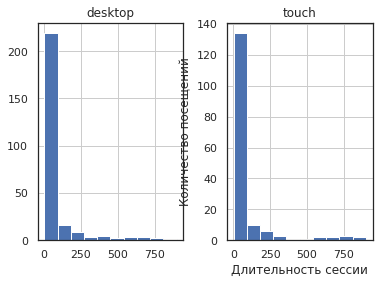

In [75]:
"""Сколько длится одна сессия?"""
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits_duration = visits.pivot_table(index='session_duration_sec', columns='device', values='uid',\
                                     aggfunc='count').\
hist(bins=10, range=(1,900))
plt.xlabel('Длительность сессии')
plt.ylabel('Количество посещений');


Самая частая длительность сессии составляет 60 секунд


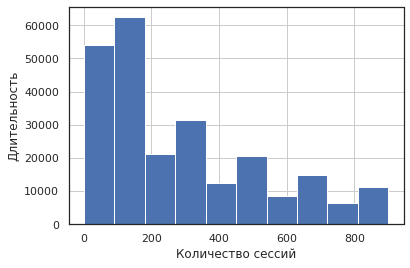

In [76]:

visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds
visits['session_duration_sec'].hist(bins=10, range=(1,900))
plt.xlabel('Количество сессий')
plt.ylabel('Длительность');
#так как распределение не похоже на нормальное,
# использование медианного и среднего значения, будет не корректно. Рассчитаем значение в выборке, которое
# встречается чаще всего

print('Самая частая длительность сессии составляет {:.0f} секунд'.format(visits['session_duration_sec'].\
                                                                         mode()[0]))
# Чаще всего сессия длится 1 минуту.

Распределение лительности сессии в обоих источниках схоже. В среднем сессия длится минуту. Скорее всего, на ресурс приходят с определенным целевым запросом. Для повышения эффективности ресурса, необходимо прорабатывать "глубину" просмотра. Так же, стоит проанализировать работу сточников, с которых совершаются переходы с короткой длительностью. Большое количество отказов говорит о некорректной работе рекламных источников.


In [77]:
"""Как часто люди возвращаются?"""
first_activity_date = visits.groupby(['uid'])['start_ts'].min() #Определим событие и период — на их основе 
#сформируем когорту. 
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')

In [78]:
#Получим месяц, за которое произошло событие. Он станет идентификатором недели.
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['visits_month'] = visits['start_ts'].astype('datetime64[M]')

In [79]:
#Рассчитаем lifetime пользователя в рамках когорты
visits['cohort_lifetime'] = visits['visits_month'] - visits['first_activity_month']
visits['cohort_lifetime'] = visits['cohort_lifetime'] / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

In [80]:
#Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей 
# на определённый месяц.
cohorts = visits.groupby(['first_activity_month','cohort_lifetime','device']).agg({'uid':'nunique'}).\
reset_index()

In [81]:
print(cohorts.head())

  first_activity_month  cohort_lifetime   device   uid
0           2017-06-01                0  desktop  9761
1           2017-06-01                0    touch  3655
2           2017-06-01                1  desktop   833
3           2017-06-01                1    touch   241
4           2017-06-01                2  desktop   593


In [82]:
#Найдём исходное количество пользователей в когорте. Возьмём их число на нулевую неделю:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid','device']]
print(initial_users_count)

    first_activity_month    uid   device
0             2017-06-01   9761  desktop
1             2017-06-01   3655    touch
24            2017-07-01   9312  desktop
25            2017-07-01   3982    touch
46            2017-08-01   7450  desktop
47            2017-08-01   2796    touch
66            2017-09-01  11715  desktop
67            2017-09-01   5133    touch
84            2017-10-01  18451  desktop
85            2017-10-01   7850    touch
100           2017-11-01  20129  desktop
101           2017-11-01   7473    touch
114           2017-12-01  18460  desktop
115           2017-12-01   7100    touch
126           2018-01-01  15809  desktop
127           2018-01-01   7018    touch
136           2018-02-01  15586  desktop
137           2018-02-01   6826    touch
144           2018-03-01  14412  desktop
145           2018-03-01   6381    touch
150           2018-04-01  10837  desktop
151           2018-04-01   4991    touch
154           2018-05-01  10252  desktop
155           20

In [83]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [84]:
#Объединим данные по когортам с исходным количеством пользователей в когорте:
cohorts = cohorts.merge(initial_users_count,on=['first_activity_month','device']).reset_index()

In [85]:
#рассчитаем Retention Rate. Разделим количество активных пользователей в каждый из месяцев на исходное число
#пользователей в когорте:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

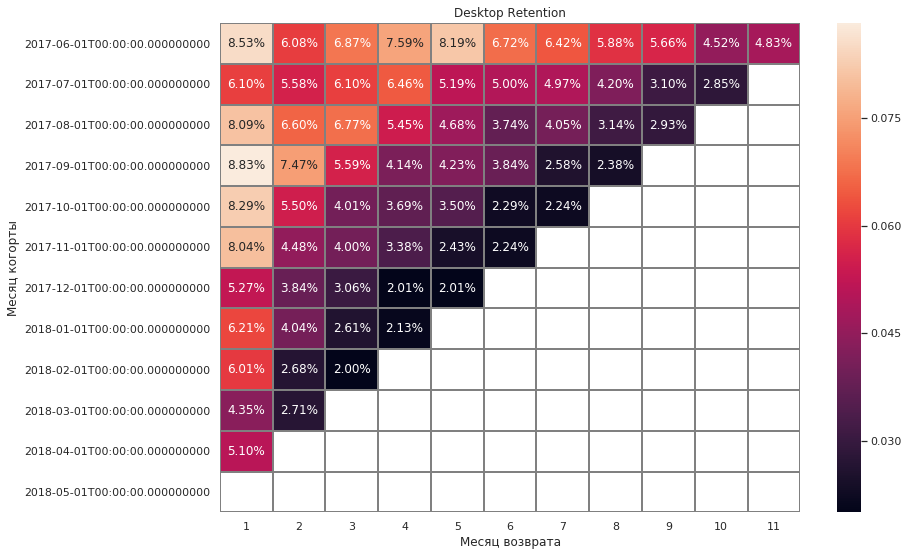

In [86]:
retention_desktop = cohorts.query('device == "desktop"').\
pivot_table( index='first_activity_month', 
        columns='cohort_lifetime', 
        values='retention', 
        aggfunc='mean')
plt.figure(figsize = (13, 9))
plt.title('Desktop Retention')
sns.heatmap(retention_desktop.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='gray')
plt.xlabel('Месяц возврата')
plt.ylabel('Месяц когорты')
plt.show()

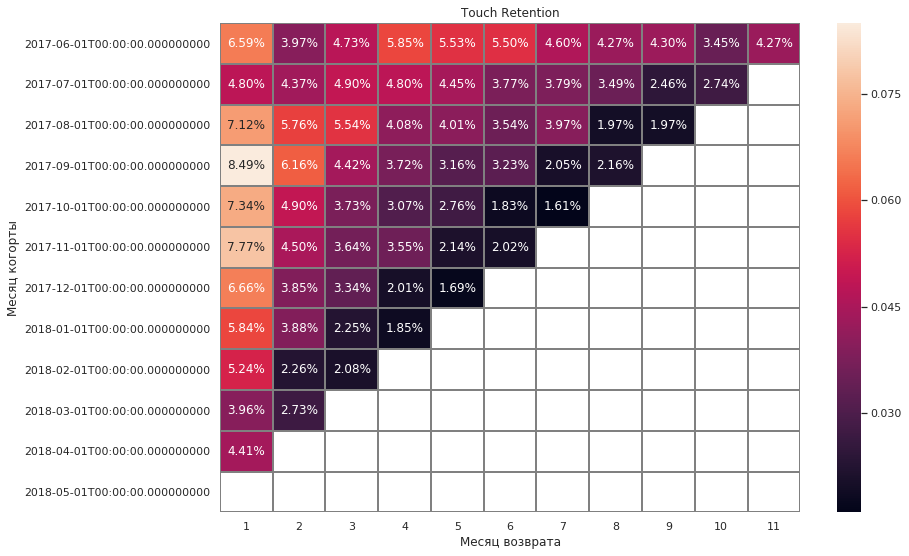

In [87]:
retention_touch = cohorts.query('device == "touch"').\
pivot_table( index='first_activity_month', 
        columns='cohort_lifetime', 
        values='retention', 
        aggfunc='mean')
plt.figure(figsize = (13, 9))
plt.title('Touch Retention')
sns.heatmap(retention_touch.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='gray')
plt.xlabel('Месяц возврата')
plt.ylabel('Месяц когорты')
plt.show()

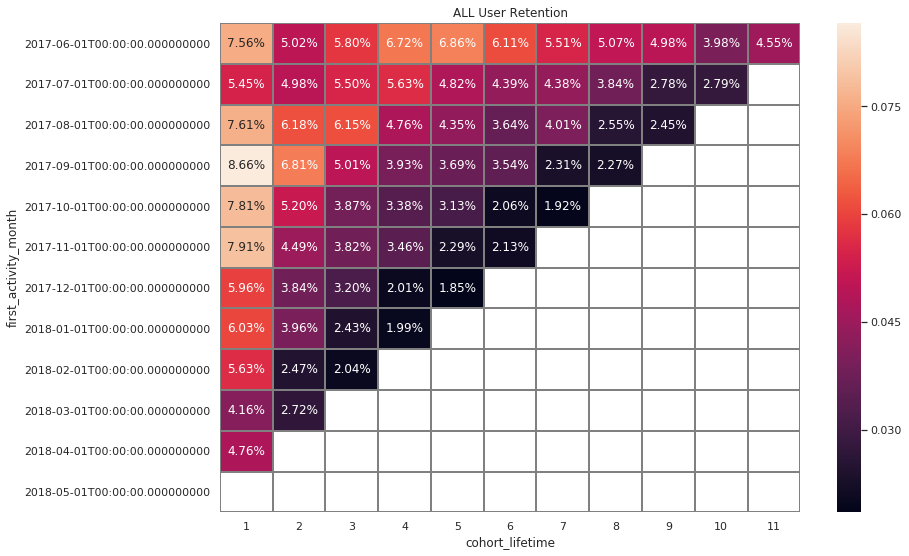

In [88]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='mean')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('ALL User Retention')
sns.heatmap(retention_pivot.iloc[:, 1:], annot=True, fmt='.2%', linewidths=1, linecolor='gray')
plt.show()

In [89]:
print('Средний Retention Rate по всем пользователям за период 5 месяцев:', round(retention_pivot[5].mean()*100,2),"%")
print('Средний Retention Rate по пользователям touch за период 5 месяцев:', round(retention_touch[5].mean()*100,2),"%")
print('Средний Retention Rate по пользователям desktop за период 5 месяцев:', round(retention_desktop[5].mean()*100,2),"%")

Средний Retention Rate по всем пользователям за период 5 месяцев: 3.85 %
Средний Retention Rate по пользователям touch за период 5 месяцев: 3.39 %
Средний Retention Rate по пользователям desktop за период 5 месяцев: 4.32 %


Общий % возврата по всем источникам за пять месяцев, довольно низкий - 3.85%
Необходимо обратить внимание на удеражние клиентов. Проработать систему лояльности, бонусную программу.
% возврата пользователей, использующих ресурс с десктопов, выше почти на 1%.


## Продажи

In [90]:
"""Когда люди начинают покупать?"""
#в таблице визитов выделим порядковый номер сессии в отдельный столбец
visits['num_of_session'] = visits.sort_values(['uid','start_ts'], ascending=[True,True]) \
             .groupby(['uid']) \
             .cumcount() + 1
visits.sort_values(by = ['uid', 'num_of_session'])

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,session_duration_sec,first_activity_date,first_activity_month,visits_month,cohort_lifetime,num_of_session
196543,touch,2018-03-01 17:33:00,3,2018-03-01 17:27:00,11863502262781,2018-01-01,2018-03-01,2018-03-01,2018-03-01,360,2018-03-01 17:27:00,2018-03-01,2018-03-01,0,1
257333,touch,2018-02-06 15:57:00,2,2018-02-06 15:55:00,49537067089222,2018-01-01,2018-02-01,2018-02-01,2018-02-06,120,2018-02-06 15:55:00,2018-02-01,2018-02-01,0,1
173818,desktop,2017-06-07 18:48:00,3,2017-06-07 18:47:00,297729379853735,2017-01-01,2017-06-01,2017-06-01,2017-06-07,60,2017-06-07 18:47:00,2017-06-01,2017-06-01,0,1
173142,desktop,2017-09-18 23:07:00,2,2017-09-18 22:49:00,313578113262317,2017-01-01,2017-09-01,2017-09-14,2017-09-18,1080,2017-09-18 22:49:00,2017-09-01,2017-09-01,0,1
192554,desktop,2018-02-18 15:26:00,2,2018-02-18 15:17:00,313578113262317,2018-01-01,2018-02-01,2018-02-15,2018-02-18,540,2017-09-18 22:49:00,2017-09-01,2018-02-01,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175259,touch,2017-12-06 20:32:00,4,2017-12-06 20:32:00,18446424184725333426,2017-01-01,2017-12-01,2017-11-30,2017-12-06,0,2017-12-06 20:32:00,2017-12-01,2017-12-01,0,1
293449,touch,2018-01-01 16:31:00,3,2018-01-01 16:29:00,18446556406699109058,2018-01-01,2018-01-01,2017-12-28,2018-01-01,120,2018-01-01 16:29:00,2018-01-01,2018-01-01,0,1
319162,desktop,2017-12-27 14:08:00,4,2017-12-27 13:27:00,18446621818809592527,2017-01-01,2017-12-01,2017-12-21,2017-12-27,2460,2017-12-27 13:27:00,2017-12-01,2017-12-01,0,1
222173,desktop,2018-05-21 09:45:00,4,2018-05-21 09:30:00,18446621818809592527,2018-01-01,2018-05-01,2018-05-17,2018-05-21,900,2017-12-27 13:27:00,2017-12-01,2018-05-01,5,2


In [91]:
#найдем время первой покупки
first_purchase = orders.groupby('uid')['buy_ts'].min().reset_index()
first_purchase.columns = ['uid', 'first_purchase']

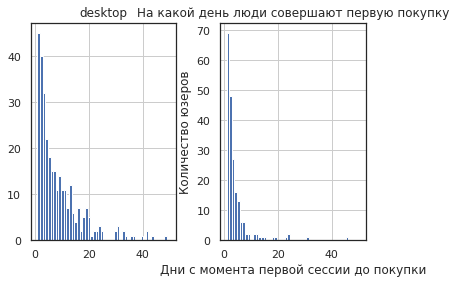

In [92]:
time_to_order = visits.merge(first_purchase, on = 'uid')
#print(time_to_order)
time_to_order_new = time_to_order[(time_to_order['start_ts'] <= time_to_order['first_purchase']) &\
                                  (time_to_order['first_purchase'] <= time_to_order['end_ts'])] 
#query('first_purchase >= start_ts and first_purchase <= end_ts')
time_to_order_new['time_to_first_purchase'] = pd.to_timedelta((time_to_order_new['first_purchase'] -\
                                                               time_to_order_new['first_activity_date']).\
                                                          dt.days, unit='d') / np.timedelta64(1,'D')
time_to_order_new.pivot_table(index='time_to_first_purchase', columns='device', values='uid', aggfunc='count').\
hist(bins=50, range=(1,50))
#time_to_order['time_to_first_purchase'].hist()
plt.title('На какой день люди совершают первую покупку')
plt.xlabel('Дни c момента первой сессии до покупки')
plt.ylabel('Количество юзеров');

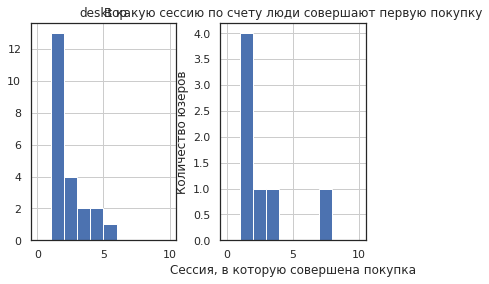

In [93]:
time_to_order_new.pivot_table(index='num_of_session', columns='device', values='uid', aggfunc='count').\
hist(range=(0,10))
plt.title('В какую сессию по счету люди совершают первую покупку')
plt.xlabel('Сессия, в которую совершена покупка')
plt.ylabel('Количество юзеров');


Чаще всего пользователи совершают первую покупку в первый день и в первую сессию в обоих источниках.


In [94]:
"""Сколько раз покупают за период?"""
orders['buy_ts'].describe() #Посмотрим на распределение дат покупок
# Даты представлены за год.Удобнее всего сформировать месячные когорты. 

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Среднее количество покупок уникального пользователя на 5 месяц: 1.4341911542792218


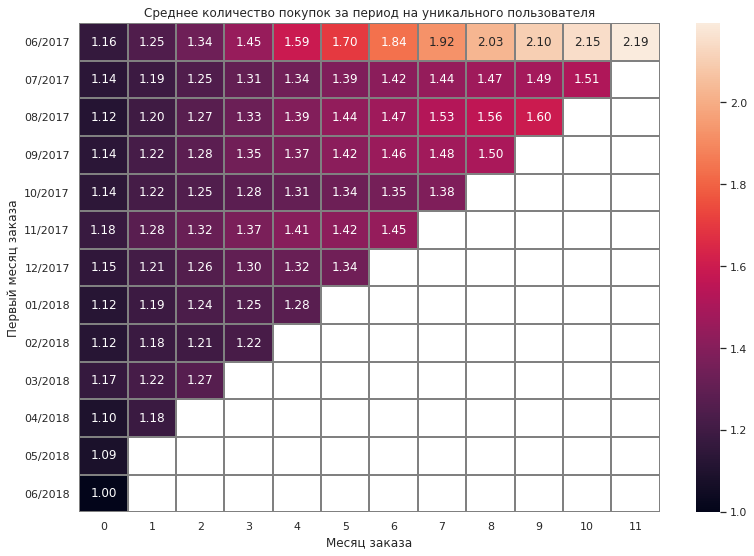

In [95]:
#определим, сколько покупок совершают пользователи за весь период
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
#найдем месяц первой покупки каждого пользователя
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']
 
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
 
#в таблицу с заказами добавим месяц первой покупки каждого пользователя
orders_new = pd.merge(orders, first_orders, on='uid')

#используя таблицу с визитами, определим из какого источника использовали ресурс впервые
source_visits = visits.sort_values(by='start_ts', ascending=True)
source_visits = source_visits.groupby(['uid'])['source_id'].first().reset_index()
orders_new = orders_new.merge(source_visits, on='uid')

#количество заказов для каждого покупателя
cohorts = orders_new.groupby(['first_order_month', 'order_month']).agg({'buy_ts':'count'}).reset_index()
cohorts = cohorts.rename(columns={'buy_ts':'order_counts'})
 
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

#возраст каждой когорты

report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M') 
report['age'] = report['age'].round().astype('int')
 
report['rate'] = report['order_counts'] / report['n_buyers']
 
#сводная таблица для построения тепловой карты
report_pivot =report.pivot_table(index='first_order_month', columns='age', values='rate', aggfunc='mean')
report_pivot.index = report_pivot.index.strftime("%m/%Y")
report_pivot = report_pivot.cumsum(axis=1)
print('Среднее количество покупок уникального пользователя на 5 месяц:', report_pivot[5].mean())
 
plt.figure(figsize=(13, 9))
plt.title('Среднее количество покупок за период на уникального пользователя')
sns.heatmap(report_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Месяц заказа')
plt.ylabel('Первый месяц заказа')

plt.show()

На период 5 месяцев уникальный пользователь совершает не больше 1 покупки. Согласно показателям первой кагорты, вторую покупку пользователь совершает через 8 месяцев. Тем не менее, вторая и третья кагорты эту практику не подтверждают. Необходимо обратить внимание на данный показатель, т.к. окупаемость продукта происходит, как правило, при повторных покупках.

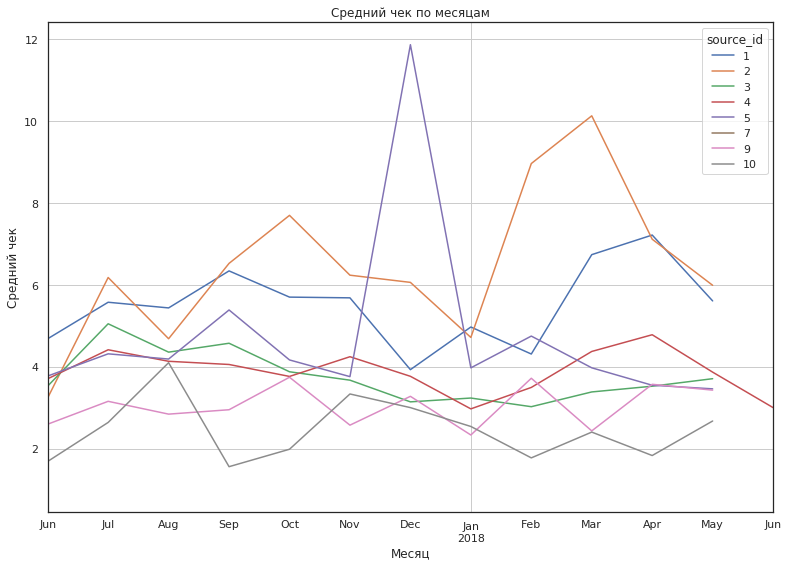

In [96]:
"""Какой средний чек?"""
average_check_pivot = orders_new.pivot_table(index='order_month',
                                             columns='source_id',
                                            values='revenue',
                                            aggfunc='mean').plot(figsize=(13, 9), grid=True)
plt.title('Средний чек по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Средний чек');

In [97]:
print('Средний чек:', orders_new['revenue'].mean())

Средний чек: 4.511732619260141


Минимальный средний чек по всем источникам - 2 usd. Основной объем продаж находится в отрезке от 3 до 6 т.р.
Источники "1" и "2" чаще "приводят" пользователей с более высоким средним чеком. Источник "5" в конце ноября "привел" самый большой чек, который поднял общий показатель.


In [98]:
"""Сколько денег приносят? (LTV)"""
cohort_sizes_source = orders_new.groupby(['first_order_month', 'source_id']).agg({'uid':'nunique'}).reset_index()
cohort_sizes_source = cohort_sizes_source.rename(columns = {'uid':'n_buyers'})
cohort_sizes_source # определили размер кагорт с привязкой к источникам

,first_order_month,source_id,n_buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
81,2018-05-01,4,804
82,2018-05-01,5,497
83,2018-05-01,9,60
84,2018-05-01,10,130


In [99]:
cogorts_source = orders_new.groupby(['first_order_month', 'order_month', 'source_id']).agg({'buy_ts':'count',
                                                                                           'revenue':'sum'}).reset_index()
cogorts_source = cogorts_source.rename(columns = {'buy_ts':'n_orders', 'revenue':'revenue_per_month'})
cogorts_source # определили количество покупок и сумму выручки отноительно кагорт с привязкой к источникам.
cogorts_source

,first_order_month,order_month,source_id,n_orders,revenue_per_month
0,2017-06-01,2017-06-01,1,268,1255
1,2017-06-01,2017-06-01,2,281,910
2,2017-06-01,2017-06-01,3,704,2483
3,2017-06-01,2017-06-01,4,467,1730
4,2017-06-01,2017-06-01,5,447,1686
...,...,...,...,...,...
511,2018-05-01,2018-05-01,4,869,3367
512,2018-05-01,2018-05-01,5,539,1809
513,2018-05-01,2018-05-01,9,62,193
514,2018-05-01,2018-05-01,10,144,400


In [100]:
report_source = pd.merge(cohort_sizes_source, cogorts_source, on=['first_order_month', 'source_id'])
report_source['cohort_lifetime'] = (report_source['order_month'] - report_source['first_order_month']) / np.timedelta64(1, 'M')
report_source['cohort_lifetime'] = report_source['cohort_lifetime'].round().astype('int')
report_source['order_per_user'] = report_source['n_orders'] / report_source['n_buyers']
report_source #объединили, подсчитали время жизни когорты

,first_order_month,source_id,n_buyers,order_month,n_orders,revenue_per_month,cohort_lifetime,order_per_user
0,2017-06-01,1,190,2017-06-01,268,1255,0,1.411
1,2017-06-01,1,190,2017-07-01,80,374,1,0.421
2,2017-06-01,1,190,2017-08-01,87,376,2,0.458
3,2017-06-01,1,190,2017-09-01,119,651,3,0.626
4,2017-06-01,1,190,2017-10-01,114,761,4,0.600
...,...,...,...,...,...,...,...,...
511,2018-05-01,4,804,2018-05-01,869,3367,0,1.081
512,2018-05-01,5,497,2018-05-01,539,1809,0,1.085
513,2018-05-01,9,60,2018-05-01,62,193,0,1.033
514,2018-05-01,10,130,2018-05-01,144,400,0,1.108


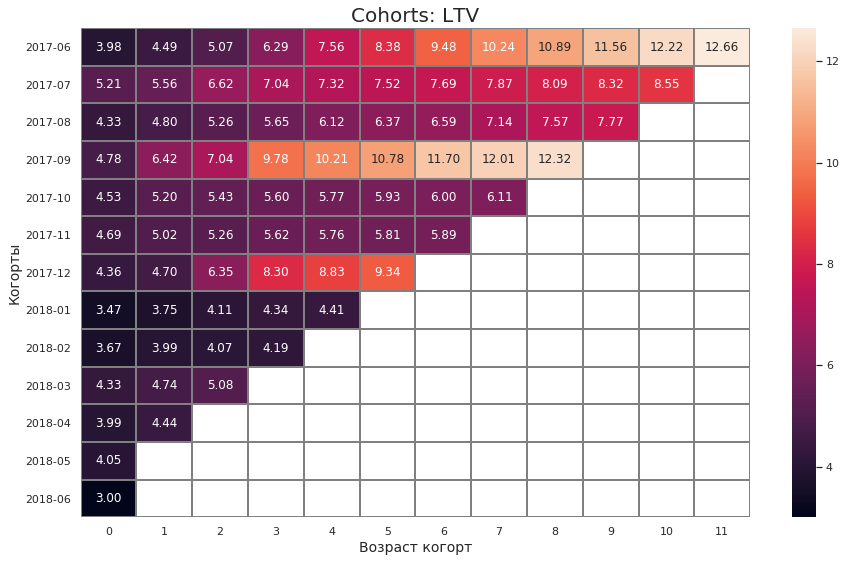

In [101]:
margin_rate = 1 #т.к. нет информации о себестоимости. Примем маржинальность за 1
report_source['gp'] = report_source['revenue_per_month'] * margin_rate #находим валовую прибыль
report_source['ltv'] = report_source['gp'] / report_source['n_buyers'] #находим LTV
report_source
result = report_source.pivot_table(
        index='first_order_month',
        columns='cohort_lifetime',
        values='ltv',
        aggfunc='mean') # сводная таблица
result.fillna('')
#result = result.cumsum(axis=1).round(2)

sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Cohorts: LTV', fontsize=20)
sns.heatmap(result.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray', yticklabels=result.index.strftime('%Y-%m'),)
plt.xlabel('Возраст когорт', fontsize=14)
plt.ylabel('Когорты', fontsize=14)
 
plt.show()

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 <a list of 13 Text yticklabel objects>)

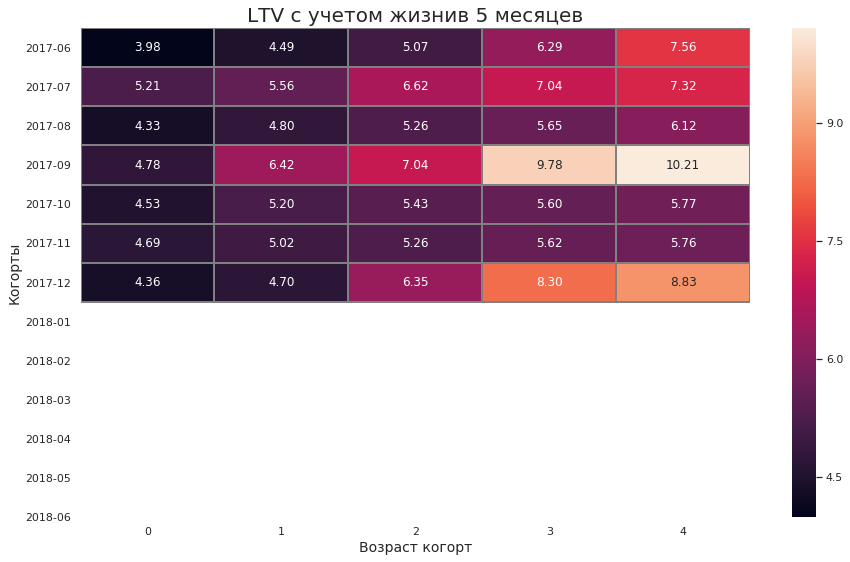

In [102]:
five_month_result = result[[0, 1, 2, 3, 4]].head(7)
five_month_result
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV с учетом жизнив 5 месяцев', fontsize=20)
sns.heatmap(five_month_result.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray', yticklabels=result.index.strftime('%Y-%m'),)
plt.xlabel('Возраст когорт', fontsize=14)
plt.ylabel('Когорты', fontsize=14)
plt.yticks(rotation=0) 

In [103]:
report_source

,first_order_month,source_id,n_buyers,order_month,n_orders,revenue_per_month,cohort_lifetime,order_per_user,gp,ltv
0,2017-06-01,1,190,2017-06-01,268,1255,0,1.411,1255,6.605
1,2017-06-01,1,190,2017-07-01,80,374,1,0.421,374,1.968
2,2017-06-01,1,190,2017-08-01,87,376,2,0.458,376,1.979
3,2017-06-01,1,190,2017-09-01,119,651,3,0.626,651,3.426
4,2017-06-01,1,190,2017-10-01,114,761,4,0.600,761,4.005
...,...,...,...,...,...,...,...,...,...,...
511,2018-05-01,4,804,2018-05-01,869,3367,0,1.081,3367,4.188
512,2018-05-01,5,497,2018-05-01,539,1809,0,1.085,1809,3.640
513,2018-05-01,9,60,2018-05-01,62,193,0,1.033,193,3.217
514,2018-05-01,10,130,2018-05-01,144,400,0,1.108,400,3.077


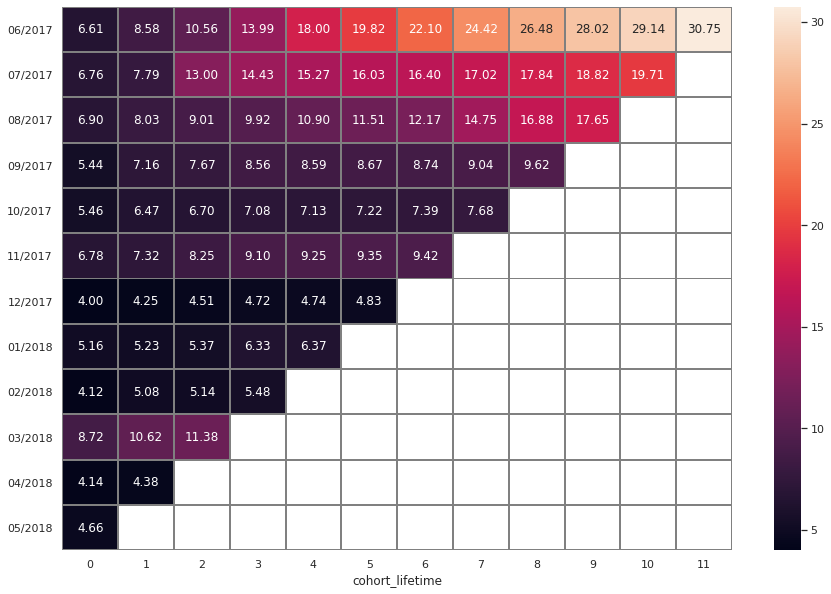

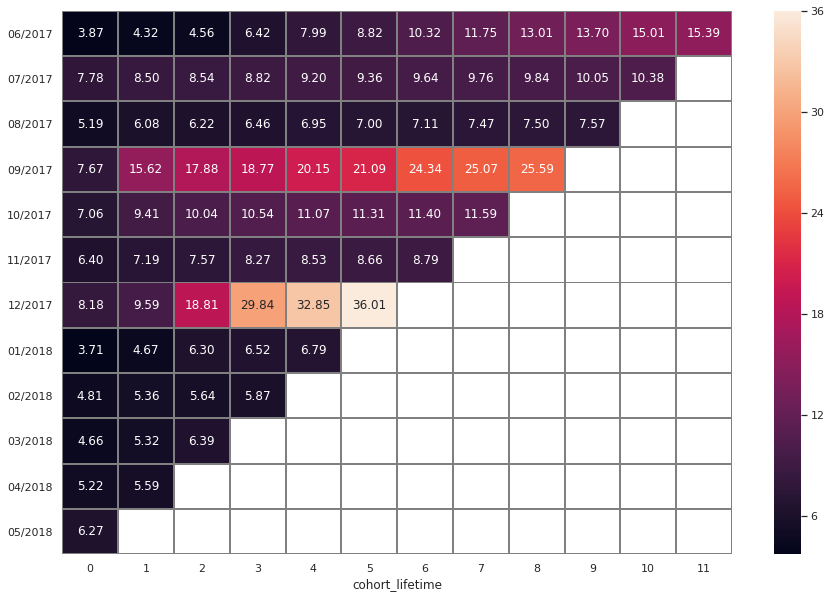

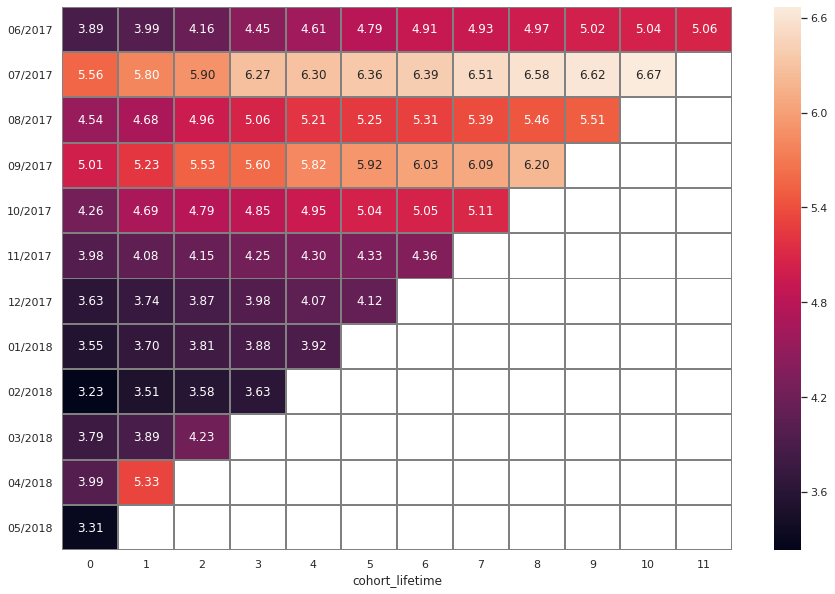

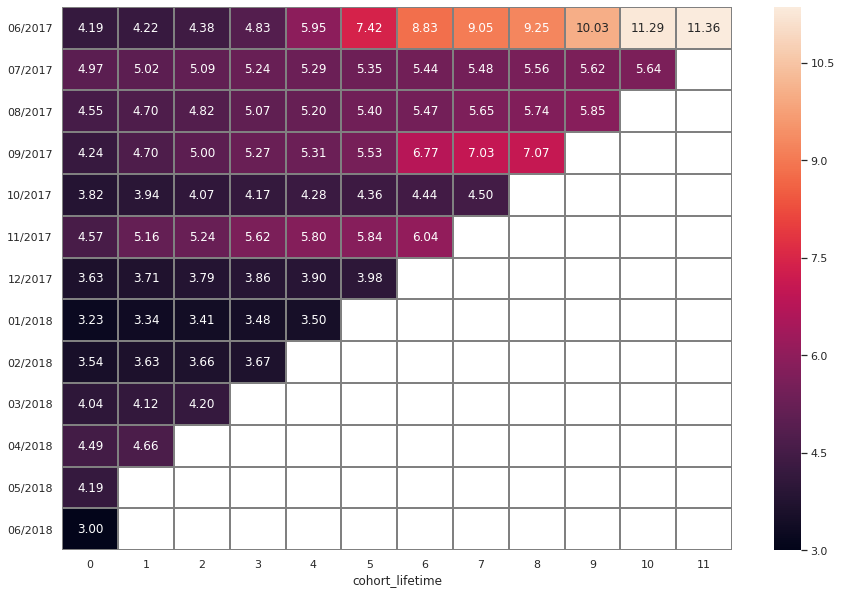

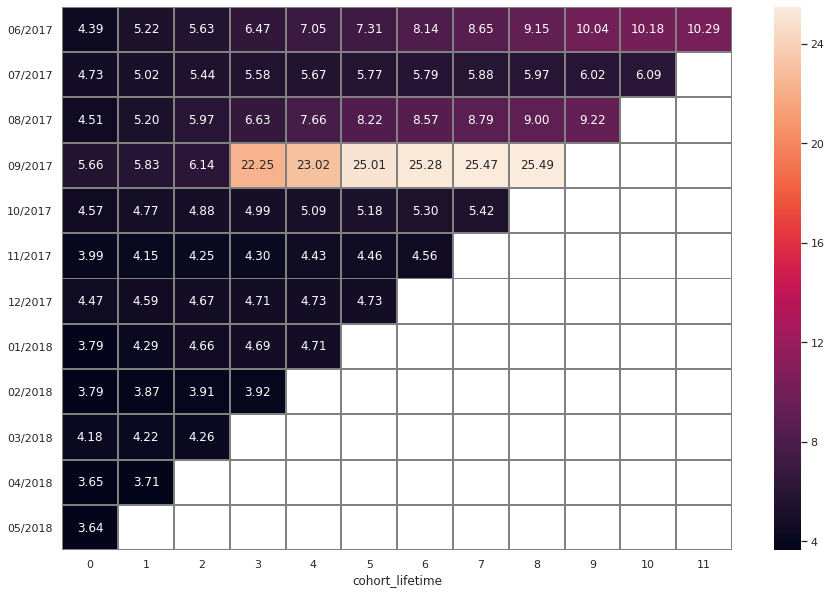

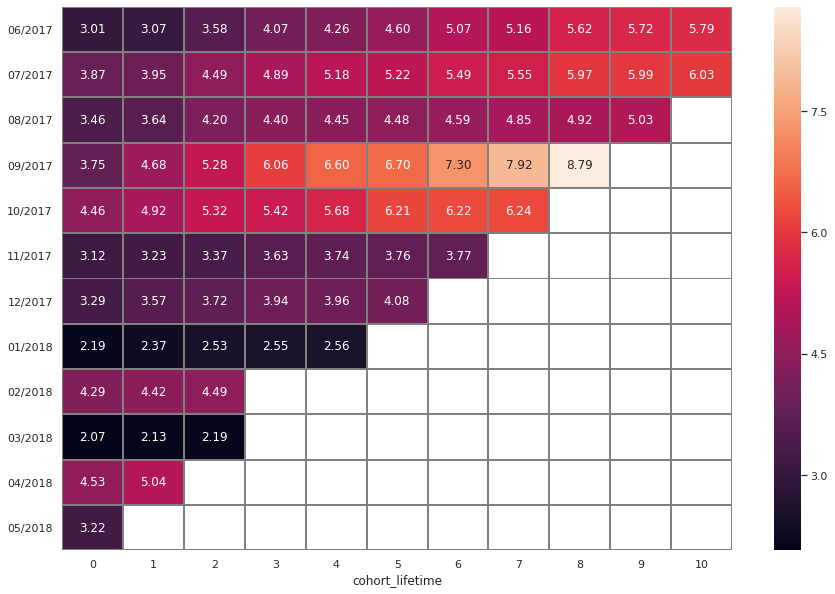

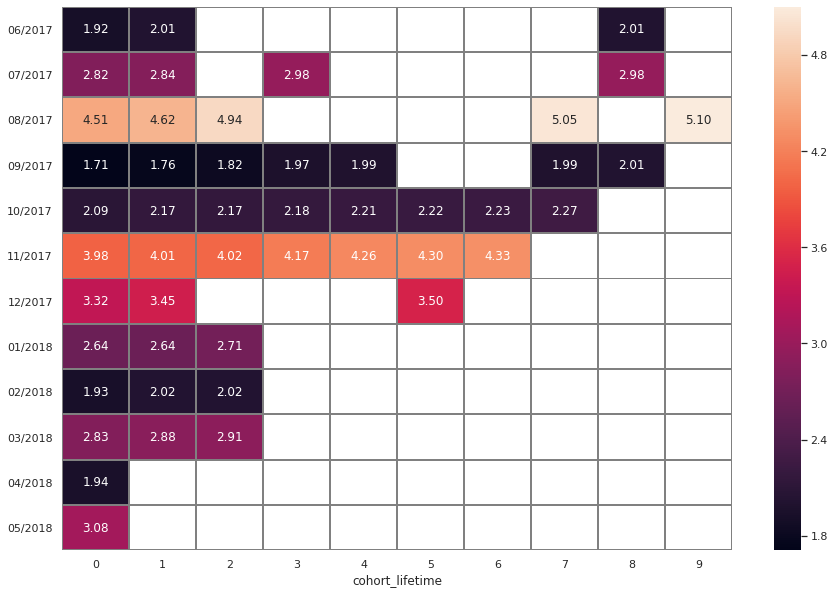

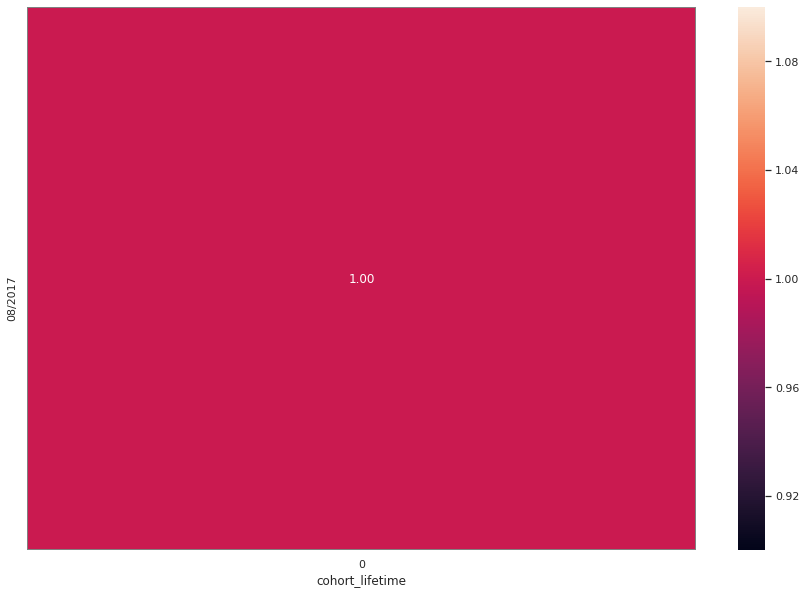

In [104]:
for source in report_source.source_id.unique():        
    output = report_source.query('source_id == @source').pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='ltv', 
        aggfunc='mean').round(2)
    output.index = output.index.strftime("%m/%Y")
    plt.figure(figsize = (15, 10))
    sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
    
    
        

Text(0, 0.5, 'Сумма')

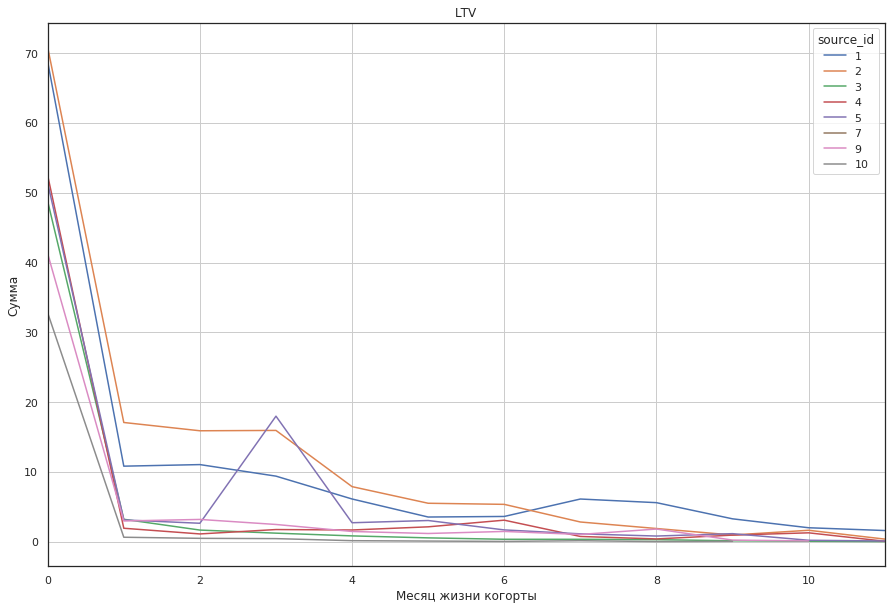

In [105]:
output = report_source.\
pivot_table(index='cohort_lifetime', columns='source_id', values='ltv', aggfunc = 'sum')
output.plot(figsize=(15,10), title ='LTV', grid=True)

plt.title('LTV')
plt.xlabel('Месяц жизни когорты')
plt.ylabel('Сумма')

In [106]:
print('Средний уровень выручки на 5 месяц жизни кагорт:', result[5].mean(axis = 0))

Средний уровень выручки на 5 месяц жизни кагорт: 0.36509934792880877


Основная выручка поступает в 0 период времени жизни кагорт. Уровень выручки подтверждает эффективность рекламных источников относительно графика среднего чека. "Лидеры" по среднему чеку - источники 1 и 2, приводят больше всего выручки. За период 5 месяцев выручка приростает от 1.24 до 5.43. При этом рост на 5.43 является скорее исключением. В среднем, 5 месяц жизни кагорт приносит 0.36 выручки. 

### Маркетинг

In [107]:
"""Сколько денег потратили? Всего / на каждый источник / по времени"""
print('Общая сумма расходов:', marketing['costs'].sum())


Общая сумма расходов: 327877


In [108]:
marketing['source_id'].unique()

array([ 1,  2,  3,  4,  5,  9, 10])

Text(0, 0.5, 'Сумма затрат')

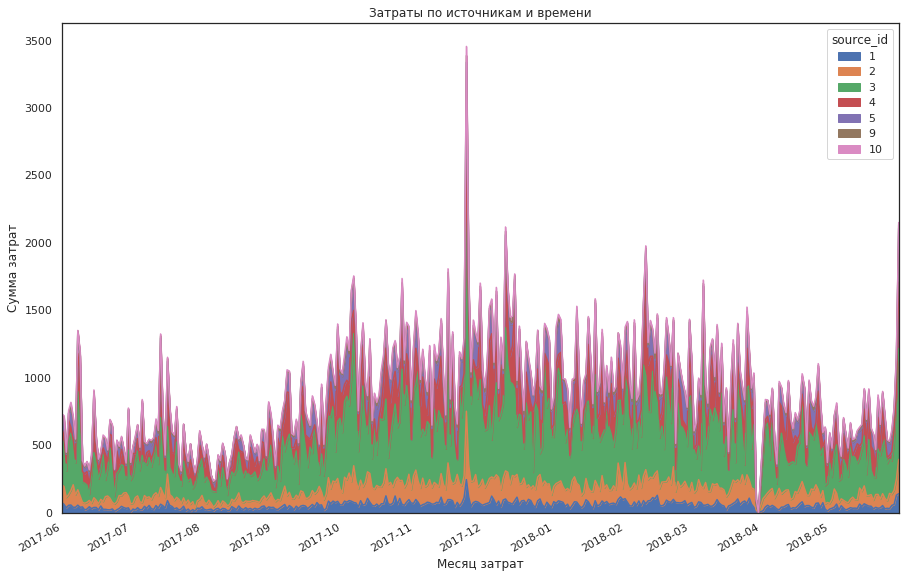

In [109]:
marketing_sourse = marketing.\
pivot_table(index='dt', columns='source_id', values='costs', aggfunc='sum')
marketing_sourse.plot(kind= 'area', figsize = (15,10))
plt.title('Затраты по источникам и времени')
plt.xlabel('Месяц затрат')
plt.ylabel('Сумма затрат')


Меньше всего затрат приходится на источники, которые принесли большую сумму выручки. Связи между расходами и уровнем LTV по источникам нет. При этом,  в расходах не учитывается  источник 7, который приносит самые не стабильные показатели по выручке. Вероятно, это бесплатный источник.

In [110]:
"""Сколько стоило привлечение одного покупателя из каждого источника? CAC"""
marketing['first_order_month'] = marketing['dt'].astype('datetime64[M]') 
test = marketing.groupby(['first_order_month', 'source_id']).agg({'costs' : 'sum'}).reset_index()
report_source_new = test.merge(report_source, on=['first_order_month', 'source_id']).reset_index()
report_source_new['cac'] = report_source_new['costs'] / report_source_new['n_buyers']
print(report_source_new.head())

   index first_order_month  source_id  costs  n_buyers order_month  n_orders  \
0      0        2017-06-01          1   1112       190  2017-06-01       268   
1      1        2017-06-01          1   1112       190  2017-07-01        80   
2      2        2017-06-01          1   1112       190  2017-08-01        87   
3      3        2017-06-01          1   1112       190  2017-09-01       119   
4      4        2017-06-01          1   1112       190  2017-10-01       114   

   revenue_per_month  cohort_lifetime  order_per_user    gp   ltv   cac  
0               1255                0           1.411  1255 6.605 5.853  
1                374                1           0.421   374 1.968 5.853  
2                376                2           0.458   376 1.979 5.853  
3                651                3           0.626   651 3.426 5.853  
4                761                4           0.600   761 4.005 5.853  


source_id
1     7.146
2    12.445
3    13.783
4     6.419
5     7.422
9     5.222
10    4.702
dtype: float64


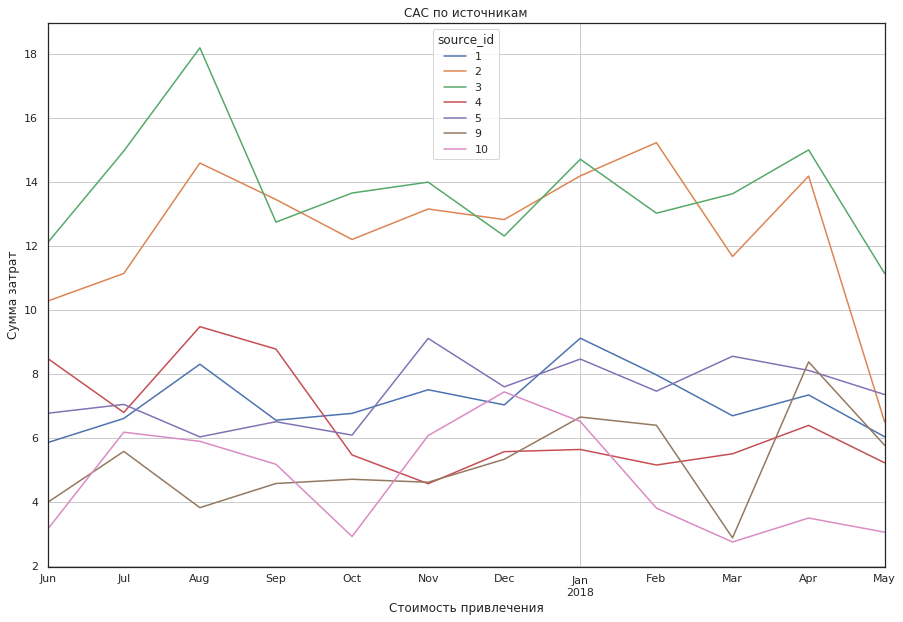

In [111]:
output_cac_sourse = report_source_new.\
pivot_table(index='first_order_month', columns='source_id', values='cac', aggfunc='mean')
output_cac_sourse.plot(figsize=(15,10), title ='CAC по источникам', grid=True)
plt.xlabel('Стоимость привлечения')
plt.ylabel('Сумма затрат');
print(output_cac_sourse.mean(axis=0))


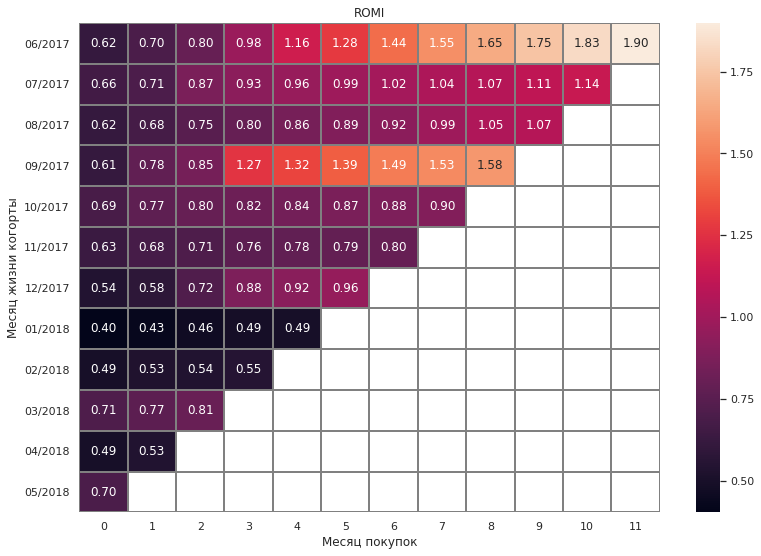

Средняя окупаемость на 5 месяц жизни кагорты: 0.04696233974986007


In [112]:
"""На сколько окупились расходы?""" 
report_source_new['romi'] = report_source_new['ltv'] / report_source_new['cac']
output_romi = report_source_new.pivot_table(
index='first_order_month',
columns='cohort_lifetime',
values='romi',
aggfunc='mean')
output_romi.index = output_romi.index.strftime("%m/%Y")
plt.figure(figsize=(13, 9))
plt.title('ROMI')
sns.heatmap(output_romi.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Месяц покупок')
plt.ylabel('Месяц жизни когорты')
plt.show()
print('Средняя окупаемость на 5 месяц жизни кагорты:', output_romi[5].mean(axis = 0))

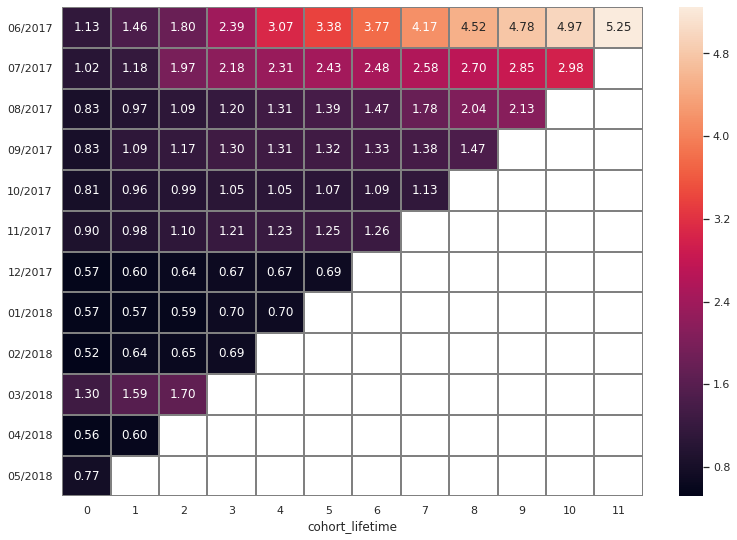

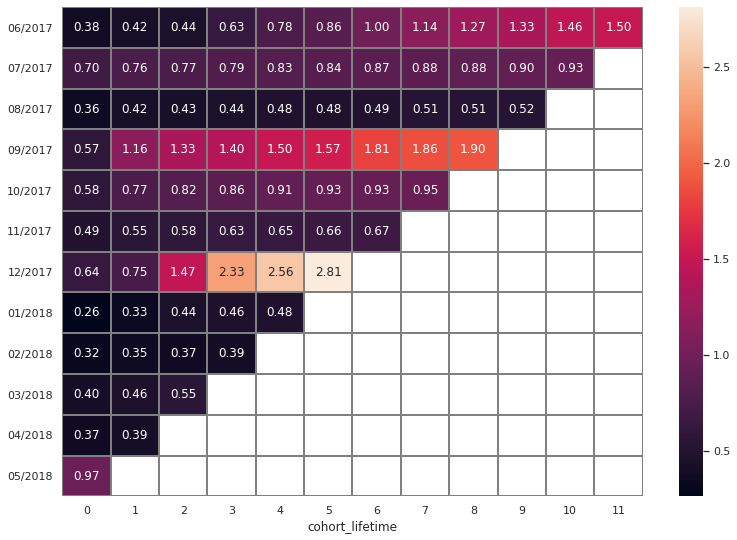

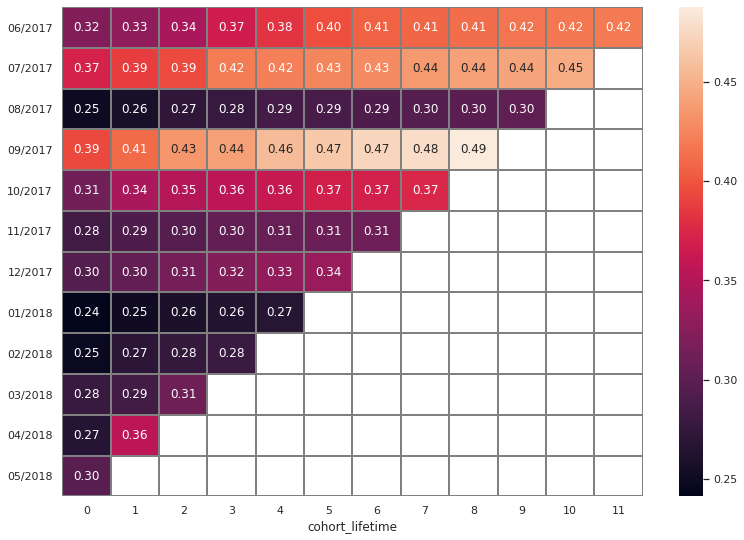

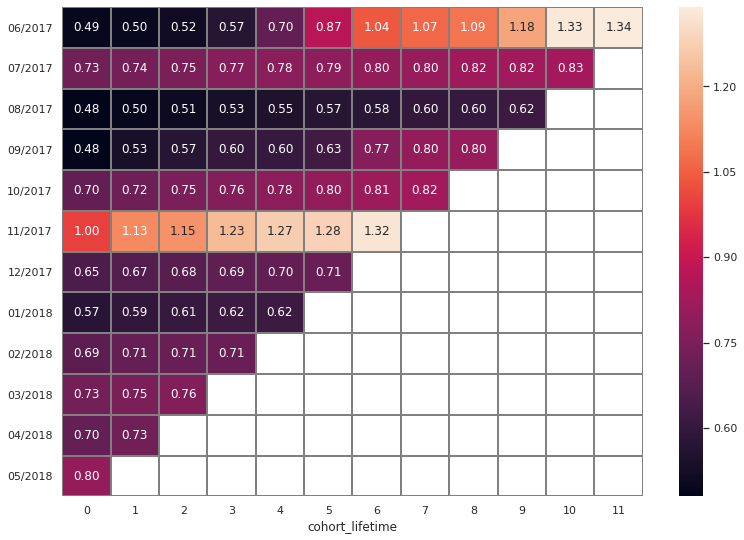

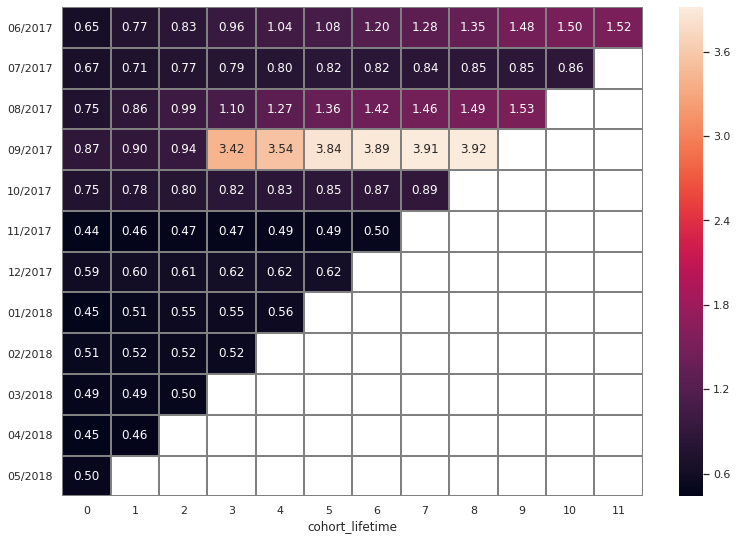

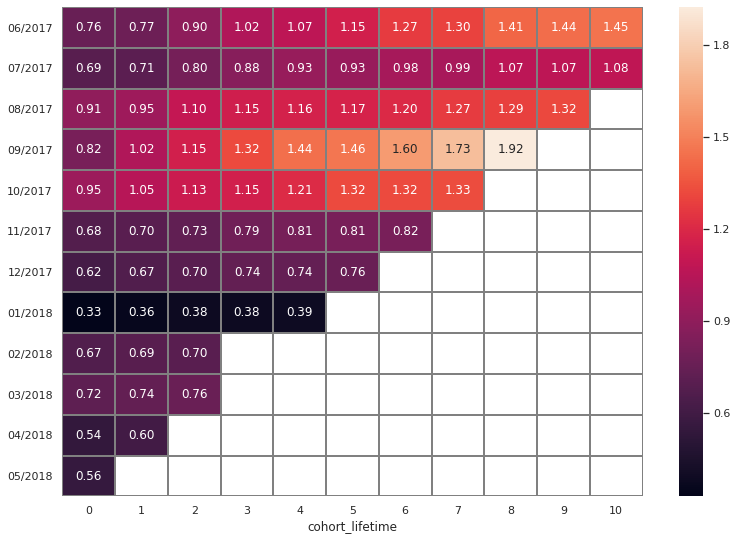

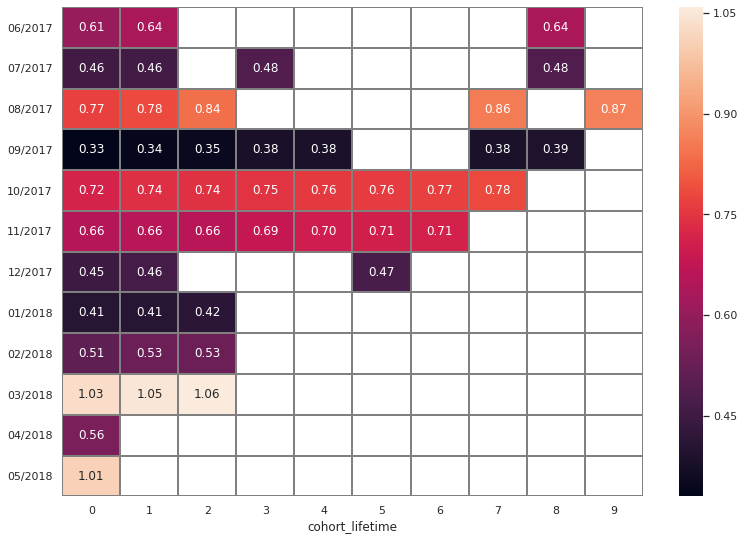

In [113]:
for source in report_source_new.source_id.unique():        
    output = report_source_new.query('source_id == @source').pivot_table(
        index='first_order_month', 
        columns='cohort_lifetime', 
        values='romi', 
        aggfunc='mean')
    output.index = output.index.strftime("%m/%Y")
    plt.figure(figsize = (13, 9))
    sns.heatmap(output.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray')


## Общие выводы

В ходе исследования было определено:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается
- как метрики отличаются по устройствам и по рекламным источникам
- Как меняются метрики во времени

Рекомендации для оптимизации маркетинговых затрат:

- Анализировать возможности трафика источников. С октября 2017 увеличились расходы на источники, что привело к росту посещаемости. Учитывая, что темп окупаемости кагорт с этого времени снизился по большинству источников, стоимость привлечения пользователя выросла. На данном этапе стоит прорабатывать конверсию из посещения в покупку.
- Необходимо прорабатывать Retention rate. Пользователь, в лучшем случае, совершает 2 покупки за год. Увеличивая частоту покупок, увеличится окупаемость.
- Окупаемость затрат не превышает 1.9 ЗА ГОД. Это низкий показатель для бизнеса.

Источник 1. Низкие затраты за привлечение из данного сточника окупаются уже на 1-3 месяц в большинстве рассматриваемых кагорт. Стоит рассмотреть возможность увеличения бюджета на этот источник.

Источник 2. Окупаемость не линейная. Вероятно на аудиторию данного источника особенно влияет сезонность. Из всех кагорт, пришли к окупаемости только 3. Вероятно, источник эффективен для дополнительного трафика в определенные месяца повышенного спроса. 

Источник 3. Высокие затраты на привлечение не окупаются ни в одной из кагорт. Ресурсы на данный источник стоит распределить на усиление других, более прибыльных.

Источник 4. Окупились только 2 кагорты. Вероятно, окупаемость наступает на 8-12 месяц жизни кагорты. Стоит увеличить бюджет на данный источник в ноябре, проанализировав аудиторию источника.

Источник 5. Первая половина кагорт либо окупается, либо близка к окупаемости, начиная с 7го месяца жизни. Кагорты с октября приростают в окупаемости медленнее, вероятно из-за увеличения стоимости привлечения. 

Источник 9. Первая половина кагорт окупается с первого месяца жизни.Источники 5 и 9 перспективны, но, вероятно, источник способен "привеодить" ограниченное количество пользователей и, при увеличении расходов, стоимость лида увеличивается, что негативно сказывается на окупаемости.

Источник 10. Источник приводит низкий средний чек и затраты на привлечение не окупаются.

Источник 7. Исходя из отсутствия расходов на привлечения из этого источника, можно сделать вывод о том, что источник - это прямые заходы на Яндекс Афишу, либо использование приложения. Выручка с данного источника не стабильная. Для увеличения выручки из данного "источника", необходимо продолжать работу над узнаваемостью, использовать имиджевые инструменты для продвижения продукта.
